In [1]:
# Standard library imports
from collections import Counter
import os
import random
import zipfile

# Third-party data science and machine learning imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split

# DICOM handling
import pydicom

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
)

# Torchvision imports
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights

In [2]:
if torch.cuda.is_available():
    print(f"GPUs Available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"- {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available.")

GPUs Available: 1

- Tesla P100-PCIE-16GB


# Local

In [3]:
# ## Dataset and Directory Configuration
# DATASET_NAME = 'rsna-mil-training'
# JOB_NAME = 'RSNA-ResNet18'
# HPC_DIR = '/media02/tdhoang01/21127112-21127734/data'
# OUTPUT_DIR = '/media02/tdhoang01/python-debugging/rsna/results'

# ZIP_FILE_PATH = os.path.join(HPC_DIR, DATASET_NAME + '.zip')
# CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'checkpoints')
# FIGURES_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'figures')
# DICOM_DIR = f'{DATASET_NAME}/'

# ## File Paths
# CSV_PATH = f'{DATASET_NAME}/training_1000_scan_subset.csv'

# ## Image Processing Parameters
# MAX_SLICES = 60
# HEIGHT = 224
# WIDTH = 224

# ## Training Hyperparameters
# BATCH_PATIENTS = 4
# NUM_EPOCHS = 2
# LEARNING_RATE = 1e-4

# ## Dataset Split Ratios
# VAL_SIZE = 0.15
# TEST_SIZE = 0.15

# ## Create Necessary Directories
# os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
# os.makedirs(FIGURES_DIR, exist_ok=True)

# ## Load CSVs from zip
# with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
#     medical_scan_data = pd.read_csv(zip_ref.open(CSV_PATH))

# Kaggle

In [4]:
# Configuration
DATASET_NAME = 'rsna-mil-training'
JOB_NAME = 'RSNA-ResNet18'
INPUT_DIR = '/kaggle/input'
OUTPUT_DIR = '/kaggle/working'

# Directories
CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'checkpoints')
FIGURES_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'figures')
DICOM_DIR = os.path.join(INPUT_DIR, DATASET_NAME, DATASET_NAME)

# File Paths
CSV_PATH = f'{DICOM_DIR}/training_1000_scan_subset.csv'

# Image Processing Parameters
MAX_SLICES = 60
HEIGHT = 224
WIDTH = 224

# Training Hyperparameters
BATCH_PATIENTS = 8
NUM_EPOCHS = 30
LEARNING_RATE = 5e-5

# Dataset Split Ratios
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# Create Necessary Directories
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Load CSV from Kaggle environment (no need to unzip)
medical_scan_data = pd.read_csv(CSV_PATH)

# Random seed
SEED = 42

In [5]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
medical_scan_data.head(1)

,patient_id,study_instance_uid,images,labels,patient_label,length
0,ID_2e010e33,ID_bda0f47e84,"['ID_b9035cb1e.dcm', 'ID_0713bed86.dcm', 'ID_5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,48


In [7]:
medical_scan_data.columns

Index(['patient_id', 'study_instance_uid', 'images', 'labels', 'patient_label',
       'length'],
      dtype='object')

# Data augmentation

In [8]:
class DatasetAugmentor:
    def __init__(self, height, width, seed=None):
        self.height = height
        self.width = width
        self.seed = seed
        
        # Store parameters for consistency checks with non-overlapping ranges
        self.min_params = self._create_transform(5, (0.05, 0.05), (0.95, 1.05), 
                                                  brightness_range=0.05, contrast_range=0.05,
                                                  blur_sigma_range=(0.1, 0.2), apply_elastic=False, level_name='min')
        self.med_params = self._create_transform(10, (0.1, 0.1), (0.9, 1.1), 
                                                  brightness_range=0.1, contrast_range=0.1,
                                                  blur_sigma_range=(0.2, 0.5), apply_elastic=True, level_name='med')
        self.max_params = self._create_transform(15, (0.2, 0.2), (0.8, 1.2), 
                                                  brightness_range=0.2, contrast_range=0.2,
                                                  blur_sigma_range=(0.5, 1.0), apply_elastic=True, level_name='max')

    def _sample_value(self, value_range):
        if isinstance(value_range, tuple):
            random.seed(self.seed)
            return random.uniform(value_range[0], value_range[1])
        return value_range

    def _create_transform(self, degrees, translate_range, scale_range,
                      brightness_range, contrast_range,
                      blur_sigma_range, apply_elastic, level_name):
        print(f"Creating '{level_name}' transform with parameters:")

        # Sample specific values and take the absolute value for positivity
        sampled_degrees = abs(self._sample_value((-degrees, degrees)) if isinstance(degrees, int) else degrees)
        sampled_translate_x = abs(self._sample_value(translate_range[0]))
        sampled_translate_y = abs(self._sample_value(translate_range[1]))
        sampled_scale = self._sample_value(scale_range)
        sampled_brightness = self._sample_value(brightness_range)
        sampled_contrast = self._sample_value(contrast_range)
        sampled_blur_sigma = self._sample_value(blur_sigma_range)

        # Print specific sampled values
        print(f"  Degrees: {sampled_degrees}, Translate: ({sampled_translate_x}, {sampled_translate_y}), Scale: {sampled_scale}")
        print(f"  Brightness: {sampled_brightness}, Contrast: {sampled_contrast}")
        print(f"  Blur Sigma: {sampled_blur_sigma}, Apply Elastic: {apply_elastic}")

        return {
            "degrees": sampled_degrees,
            "translate": (sampled_translate_x, sampled_translate_y),
            "scale": sampled_scale,
            "brightness": sampled_brightness,
            "contrast": sampled_contrast,
            "blur_sigma": sampled_blur_sigma,
            "apply_elastic": apply_elastic
        }

    def apply_transform(self, image, level):        
        if self.seed is not None:
            torch.manual_seed(self.seed)
            random.seed(self.seed)

        if level == 0:
            params = self.min_params
            transform = self._get_transform(params)
        elif level == 1:
            params = self.med_params
            transform = self._get_transform(params)
        else:
            params = self.max_params
            transform = self._get_transform(params)

        transformed_image = transform(image)        
        return transformed_image

    def _get_transform(self, params):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=params["degrees"], translate=params["translate"], scale=(params["scale"], params["scale"])),
            transforms.ColorJitter(brightness=params["brightness"], contrast=params["contrast"]),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=params["blur_sigma"]),
            transforms.RandomApply([transforms.ElasticTransform()] if params["apply_elastic"] else [], p=0.3),
            transforms.Resize(256),
            transforms.CenterCrop(HEIGHT),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.16774411, 0.1360026, 0.19076315], std=[0.3101935, 0.27605791, 0.30469988]),
            transforms.RandomApply([self._channel_shuffle], p=0.3)
        ])

    def _channel_shuffle(self, tensor):
        torch.manual_seed(self.seed)
        channels = tensor.shape[0]
        indices = torch.randperm(channels)
        return tensor[indices]

In [9]:
augmentor = DatasetAugmentor(HEIGHT, WIDTH, seed=SEED)

Creating 'min' transform with parameters:

  Degrees: 1.3942679845788373, Translate: (0.05, 0.05), Scale: 1.0139426798457885

  Brightness: 0.05, Contrast: 0.05

  Blur Sigma: 0.16394267984578836, Apply Elastic: False

Creating 'med' transform with parameters:

  Degrees: 2.7885359691576745, Translate: (0.1, 0.1), Scale: 1.027885359691577

  Brightness: 0.1, Contrast: 0.1

  Blur Sigma: 0.3918280395373651, Apply Elastic: True

Creating 'max' transform with parameters:

  Degrees: 4.182803953736514, Translate: (0.2, 0.2), Scale: 1.0557707193831534

  Brightness: 0.2, Contrast: 0.2

  Blur Sigma: 0.8197133992289418, Apply Elastic: True


# Local dataset gen.

# Kaggle dataset gen.

In [10]:
class MedicalScanDataset(Dataset):
    def __init__(self, dicom_dir, medical_scan_data, max_slices, height, width, augmentor):
        self.dicom_dir = dicom_dir
        self.medical_scan_data = self._parse_medical_scan_data(medical_scan_data)
        self.max_slices = max_slices
        self.height = height
        self.width = width
        self.augmentor = augmentor

    def __len__(self):
        return len(self.medical_scan_data) * 3

    def __getitem__(self, idx):
        # Determine patient and augmentation level
        patient_idx = idx // 3
        level = idx % 3

        row = self.medical_scan_data.iloc[patient_idx]
        dicom_files = self._get_dicom_files(row)
        labels = torch.tensor(row['labels'], dtype=torch.float32)
        patient_label = torch.tensor(row['patient_label'], dtype=torch.float32)

        # Process DICOM files and apply augmentations
        images = [self._process_dicom_file(dicom_file) for dicom_file in dicom_files]
        transformed_images = [self.augmentor.apply_transform(img, level) for img in images]

        # Pad images if less than max_slices
        while len(transformed_images) < self.max_slices:
            transformed_images.append(torch.zeros(3, self.height, self.width))

        # Convert list to tensor
        image_tensor = torch.stack(transformed_images[:self.max_slices])

        # Pad labels if necessary
        if len(labels) < self.max_slices:
            label_padding = torch.zeros(self.max_slices - len(labels), dtype=torch.float32)
            labels = torch.cat((labels, label_padding))

        return image_tensor, labels, patient_label

    def _parse_medical_scan_data(self, medical_scan_data):
        medical_scan_data['images'] = medical_scan_data['images'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        medical_scan_data['labels'] = medical_scan_data['labels'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        medical_scan_data['patient_label'] = medical_scan_data['patient_label'].astype(bool)
        return medical_scan_data

    def _get_dicom_files(self, row):
        """Retrieve and sort DICOM files by z-coordinate."""
        patient_id = row['patient_id'].replace("ID_", "")
        study_instance_uid = row['study_instance_uid'].replace("ID_", "")
        dicom_dir_path = os.path.join(self.dicom_dir, f"{patient_id}_{study_instance_uid}")

        dicom_files = []
        if os.path.exists(dicom_dir_path):
            slices = []
            for image in row['images']:
                dicom_file_path = os.path.join(dicom_dir_path, image)
                if os.path.exists(dicom_file_path):
                    slices.append(dicom_file_path)

            # Sort by z-coordinate if available
            dicom_files = sorted(slices, key=lambda x: float(pydicom.dcmread(x).ImagePositionPatient[2]) if hasattr(pydicom.dcmread(x), 'ImagePositionPatient') else 0)

        return dicom_files

    def _process_dicom_file(self, dicom_file):
        """Load and preprocess a DICOM file."""
        try:
            dicom = pydicom.dcmread(dicom_file)
            img = self._preprocess_slice(dicom)
            return torch.from_numpy(img).float()
        except Exception as e:
            print(f"Error processing {dicom_file}: {e}")
            return torch.zeros(3, self.height, self.width)

    def _preprocess_slice(self, dicom):
        """Apply windowing to extract relevant image data."""
        brain_img = self._window_image(dicom, 40, 80)
        subdural_img = self._window_image(dicom, 80, 200)
        soft_img = self._window_image(dicom, 40, 380)

        normalized_images = np.array([
            (brain_img - 0) / 80,
            (subdural_img - (-20)) / 200,
            (soft_img - (-150)) / 380
        ])

        return normalized_images.astype(np.float16)

    def _window_image(self, dcm, window_center, window_width):
        """Apply windowing and resize the DICOM image."""
        img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        return cv2.resize(img, (self.height, self.width), interpolation=cv2.INTER_LINEAR)

    def calculate_mean_std(self):
        """Calculate mean and standard deviation across dataset."""
        total_mean = np.zeros(3)
        total_var = np.zeros(3)
        total_count = 0
        
        for idx in range(len(self.medical_scan_data)):
            row = self.medical_scan_data.iloc[idx]
            dicom_files = self._get_dicom_files(row)
            
            for dicom_file in dicom_files:
                img = self._process_dicom_file(dicom_file)
                img_np = img.numpy()
                
                if np.all(img_np == 0):
                    continue
                
                mean = np.mean(img_np, axis=(1, 2))
                var = np.var(img_np, axis=(1, 2))
                
                total_count += img_np.shape[1] * img_np.shape[2]
                total_mean += mean * (img_np.shape[1] * img_np.shape[2])
                total_var += var * (img_np.shape[1] * img_np.shape[2]) + (mean**2) * (img_np.shape[1] * img_np.shape[2])
        
        final_mean = total_mean / total_count
        final_var = total_var / total_count - (final_mean**2)
        final_std = np.sqrt(final_var)

        return final_mean, final_std

In [11]:
medical_scan_dataset = MedicalScanDataset(
    dicom_dir=DICOM_DIR,
    medical_scan_data=medical_scan_data,
    max_slices=MAX_SLICES,
    height=HEIGHT,
    width=WIDTH,
    augmentor=augmentor
)

In [12]:
# final_mean, final_std = medical_scan_dataset.calculate_mean_std()
# print("Mean:", final_mean)
# print("Standard Deviation:", final_std)

In [13]:
print(len(medical_scan_dataset))

3000


In [14]:
images, labels, patient_label = medical_scan_dataset[0]
print("Shape of image tensor:", images.shape)
print("Label:", labels)
print("Patient label: ", patient_label)

Shape of image tensor: torch.Size([60, 3, 224, 224])

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Patient label:  tensor(0.)


# Plot original vs augmented data

In [15]:
def plot_augmented_images(dataset, index):
    fig, axes = plt.subplots(3, 20, figsize=(20, 4), dpi=128)
    fig.suptitle(f"Augmentation levels for dataset[{index}] - Patient Label: {dataset.medical_scan_data.iloc[index // 3]['patient_label']}")
    
    for level in range(3):
        images, labels, patient_label = dataset[index * 3 + level]
        
        # Limit to first 20 images
        for i in range(min(20, len(images))):
            img = images[i].numpy().transpose(1, 2, 0)
            ax = axes[level, i]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f"Slice {i+1}\nLabel: {labels[i].item()}", fontsize=6)
    
    plt.tight_layout()
    plt.show()

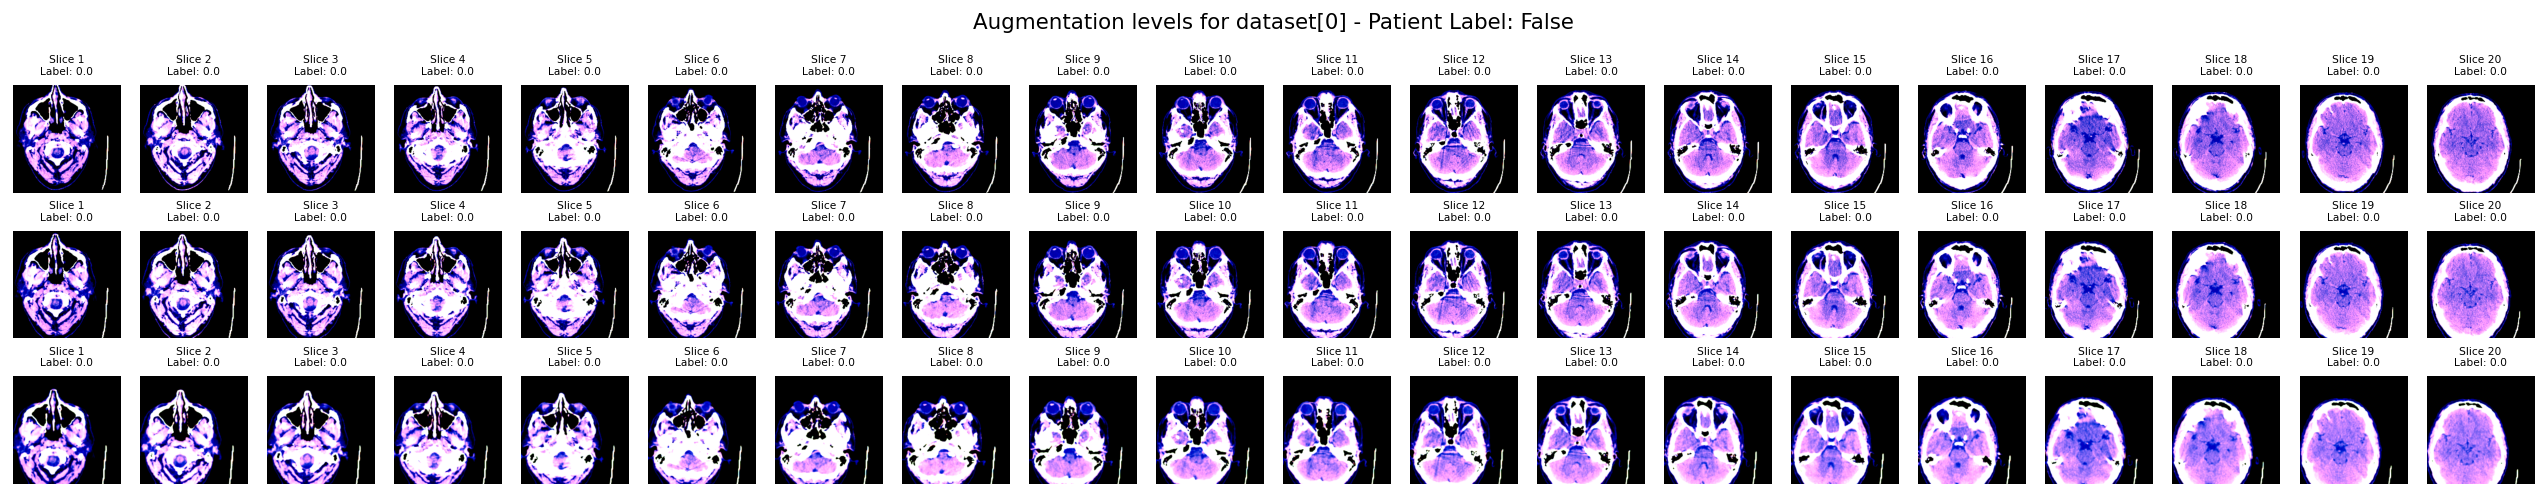

In [16]:
plot_augmented_images(medical_scan_dataset, index=0)

# Dataloader

In [17]:
class DataloaderManager:
    def __init__(self, dataset, val_size, test_size, batch_size, num_workers=4, seed=SEED):
        self.seed = seed
        self.dataset = dataset
        self.val_size = val_size
        self.test_size = test_size
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_loader, self.validate_loader, self.test_loader = self._create_loaders()

    def _split_indices(self):
        labels = np.array(self.dataset.medical_scan_data['patient_label'].tolist())
        indices = np.arange(len(labels) * 3)

        original_labels = np.repeat(labels, 3)
        train_val_indices, test_indices = train_test_split(
            indices, test_size=self.test_size, stratify=original_labels, random_state=self.seed
        )

        val_relative_size = self.val_size / (1 - self.test_size)
        train_indices, val_indices = train_test_split(
            train_val_indices, test_size=val_relative_size, stratify=original_labels[train_val_indices], random_state=self.seed
        )

        return train_indices, val_indices, test_indices

    def _create_dataloader(self, indices, shuffle=True):
        return DataLoader(
            Subset(self.dataset, indices), batch_size=self.batch_size, shuffle=shuffle,
            num_workers=self.num_workers, pin_memory=True,
            worker_init_fn=self._init_worker
        )

    def _init_worker(self, worker_id):
        np.random.seed(self.seed + worker_id)

    def _create_loaders(self):
        train_indices, val_indices, test_indices = self._split_indices()
        train_loader = self._create_dataloader(train_indices)
        validate_loader = self._create_dataloader(val_indices)
        test_loader = self._create_dataloader(test_indices)
        return train_loader, validate_loader, test_loader

    def print_patient_label_distribution(self):
        all_labels = np.array(self.dataset.medical_scan_data['patient_label'].tolist())
        
        repeated_labels = np.repeat(all_labels, 3)

        train_indices = self.train_loader.dataset.indices
        val_indices = self.validate_loader.dataset.indices
        test_indices = self.test_loader.dataset.indices

        train_counts = np.bincount(repeated_labels[train_indices].astype(int))
        val_counts = np.bincount(repeated_labels[val_indices].astype(int))
        test_counts = np.bincount(repeated_labels[test_indices].astype(int))

        print(f'Train Patient Label Distribution: {train_counts}')
        print(f'Validation Patient Label Distribution: {val_counts}')
        print(f'Test Patient Label Distribution: {test_counts}')

In [18]:
dataloader_manager = DataloaderManager(medical_scan_dataset, val_size=VAL_SIZE, test_size=TEST_SIZE, batch_size=BATCH_PATIENTS)

In [19]:
dataloader_manager.print_patient_label_distribution()

Train Patient Label Distribution: [1049 1050]

Validation Patient Label Distribution: [226 225]

Test Patient Label Distribution: [225 225]


# Model configurations

In [20]:
# class GPModel(gpytorch.models.ApproximateGP):
#     def __init__(self, inducing_points):
#         variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
#         variational_strategy = gpytorch.variational.VariationalStrategy(
#             self, inducing_points, variational_distribution, learn_inducing_locations=True
#         )
#         super(GPModel, self).__init__(variational_strategy)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [21]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Tanh(),
            # nn.ReLU(),
            nn.PReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, num_instances, feature_dim)
        attention_weights = self.attention(x)
        weights = nn.functional.softmax(attention_weights, dim=1)

        return (x * weights).sum(dim=1), weights.squeeze(-1)

In [22]:
# 2. Model Definition
class ResNet18(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Identity()
        self.dropout = nn.Dropout(p=0.1)
        self.attention = AttentionLayer(input_dim=512, hidden_dim=512)
        self.fc = nn.Linear(512, 1)
        
    def forward(self, x):
        # x: (batch_size, bag_size, channels, height, width)
        batch_size, bag_size = x.size(0), x.size(1)
        
        # Reshape to (batch_size * bag_size, channels, height, width)
        x = x.view(-1, *x.shape[2:])
        
        features = self.model(x)
        
        assert features.shape[1] == 512, f"Expected features to have shape [*, 512] but got {features.shape}"
        
        # Reshape back to (batch_size, bag_size, feature_dim)
        features = features.view(batch_size, bag_size, -1)
        
        attended_features, attended_weights = self.attention(features)
        attended_features_reshaped = attended_features.view(-1, 512)
        
        return self.dropout(self.fc(attended_features_reshaped)), attended_weights

In [23]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
model = ResNet18().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


In [24]:
# 3. Loss and Optimizer
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

# mode: Monitors 'min' or 'max' changes in metrics.
# factor: The multiplicative factor for reducing the learning rate. 
##  If the current learning rate is 0.01 and factor=0.5, the new learning rate will be 0.01 * 0.5 = 0.005
# patience: Number of epochs to wait for improvement before reducing the learning rate.

In [25]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (image, _, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        # Forward pass
        optimizer.zero_grad()
        
        outputs, attention_weights = model(image)
        output = outputs.squeeze()
        
        label = label.reshape(-1)
        
        loss = criterion(output, label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted_label = (output > 0.5).float()
        total += label.size(0)
        correct += (predicted_label == label).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}%')

    scheduler.step(epoch_loss)
    return epoch_loss

In [26]:
def validate(model, validate_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for batch_idx, (image, _, label) in enumerate(validate_loader):
            image, label = image.to(device), label.to(device)
            
            # Forward pass
            outputs, attention_weights = model(image)

            output = outputs.squeeze()
            label = label.reshape(-1)
            
            loss = criterion(output, label)
            running_loss += loss.item()
            
            # Calculate accuracy
            predicted_label = (output > 0.5).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
    
    val_loss = running_loss / len(validate_loader)
    accuracy = 100 * correct / total
    
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}%')
    
    return val_loss

In [27]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss):
    checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'checkpoint_epoch_{epoch+1}.pth')    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

In [28]:
def load_best_checkpoint(model, optimizer, scheduler, checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch_') and f.endswith('.pth')]
    if not checkpoint_files:
        print("No checkpoints found.")
        return None, None

    best_checkpoint = min(checkpoint_files, key=lambda x: float(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint)
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device(device), weights_only=True)
    except RuntimeError as e:
        print(f"Error loading checkpoint: {e}")
        print(f"Checkpoint file: {checkpoint_path}")
        print(f"File size: {os.path.getsize(checkpoint_path)} bytes")
        return None, None

    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        epoch = checkpoint['epoch']
        best_val_loss = checkpoint['loss']
        
        print(f"Loaded checkpoint from epoch {epoch+1} with validation loss {best_val_loss}")
        
        return epoch, best_val_loss
    except KeyError as e:
        print(f"Error: Checkpoint file is missing expected data: {e}")
        print(f"Available keys in checkpoint: {checkpoint.keys()}")
        return None, None

In [29]:
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve.png'))
    plt.show()
    plt.close()

In [30]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix.png'))
    plt.show()
    plt.close()

In [31]:
def save_final_model(model, optimizer, scheduler, final_model_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")

In [32]:
def evaluate(model, test_loader, device, criterion):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_scores = []
    test_loss = 0

    with torch.inference_mode():
        for image, _, label in test_loader:
            image, label = image.to(device), label.to(device)
            
            outputs, attention_weights = model(image)

            output = outputs.squeeze()
            label = label.reshape(-1)
            
            loss = criterion(output, label)
            test_loss += loss.item()
            
            predicted_label = (output > 0.5).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
            
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted_label.cpu().numpy())
            all_scores.extend(output.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f'Test Accuracy: {accuracy:.4f}%')
    print(f'Test Loss: {avg_loss:.4f}')
    
    plot_roc_curve(np.array(all_labels), np.array(all_scores))
    plot_confusion_matrix(np.array(all_labels), np.array(all_predictions))

    return accuracy, avg_loss

# Main

## Train result

In [33]:
loaded_epoch, loaded_best_val_loss = load_best_checkpoint(model, optimizer, scheduler, CHECKPOINTS_DIR)

if loaded_epoch is not None:
    start_epoch = loaded_epoch + 1
    best_val_loss = loaded_best_val_loss
else:
    start_epoch = 0
    best_val_loss = float('inf')

train_loader = dataloader_manager.train_loader
validate_loader = dataloader_manager.validate_loader
test_loader = dataloader_manager.test_loader
    
for epoch in range(start_epoch, NUM_EPOCHS):
    train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss = validate(model, validate_loader, criterion, device)
    
    if val_loss < best_val_loss:
        save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
        best_val_loss = val_loss

No checkpoints found.

Epoch 1: Loss: 0.5246, Accuracy: 71.3197%

Validation Loss: 0.3517, Validation Accuracy: 81.8182%

Checkpoint saved: /kaggle/working/RSNA-ResNet18/checkpoints/checkpoint_epoch_1.pth

Epoch 2: Loss: 0.3951, Accuracy: 79.5141%

Validation Loss: 0.3240, Validation Accuracy: 82.9268%

Checkpoint saved: /kaggle/working/RSNA-ResNet18/checkpoints/checkpoint_epoch_2.pth

Epoch 3: Loss: 0.3099, Accuracy: 85.2311%

Validation Loss: 0.2791, Validation Accuracy: 87.3614%

Checkpoint saved: /kaggle/working/RSNA-ResNet18/checkpoints/checkpoint_epoch_3.pth

Epoch 4: Loss: 0.2727, Accuracy: 85.6122%

Validation Loss: 0.3411, Validation Accuracy: 87.1397%

Epoch 5: Loss: 0.2189, Accuracy: 89.2330%

Validation Loss: 0.2707, Validation Accuracy: 86.4745%

Checkpoint saved: /kaggle/working/RSNA-ResNet18/checkpoints/checkpoint_epoch_5.pth

Epoch 6: Loss: 0.1886, Accuracy: 90.2334%

Validation Loss: 0.1945, Validation Accuracy: 91.3525%

Checkpoint saved: /kaggle/working/RSNA-ResNet18

## Evaluate result

Test Accuracy: 97.5556%

Test Loss: 0.0716


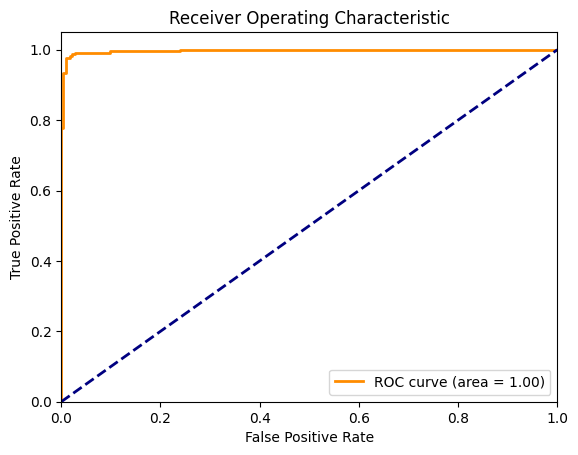

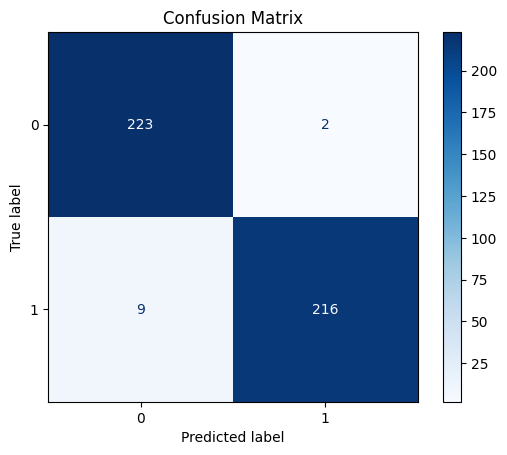

Final model saved to /kaggle/working/RSNA-ResNet18/checkpoints/final_model.pth


In [34]:
accuracy, test_loss = evaluate(model, test_loader, device, criterion)

final_model_path = os.path.join(CHECKPOINTS_DIR, 'final_model.pth')
save_final_model(model, optimizer, scheduler, final_model_path)

# Plot with attention

In [35]:
def plot_images_with_attention(test_loader, model, device):
    model.eval()
    found_labels = {0: False, 1: False}  # Track if we've found a patient for each label
    with torch.no_grad():
        for image, _, label in test_loader:
            image, label = image.to(device), label.to(device)
            outputs, attention_weights = model(image)
            # Reshape attention weights to match the original input shape
            attention_weights = attention_weights.view(image.size(0), -1)  # (batch_size, bag_size)
            for i in range(image.size(0)):
                # Retrieve patient label
                patient_label = label[i].item()
                
                # Check if we need to plot this patient's images
                if patient_label in [0, 1] and not found_labels[patient_label]:
                    found_labels[patient_label] = True
                    
                    plt.figure(figsize=(16, 8))
                    fig, axes = plt.subplots(10, 6, figsize=(16, 24))  # Adjust figure size for larger images
                    for j in range(MAX_SLICES):
                        if j < image.size(1):  # Ensure we do not exceed available slices
                            ax = axes[j // 6, j % 6]  # Access subplot at row (j // 6) and column (j % 6)
                            ax.imshow(image[i, j].cpu().numpy().transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
                            ax.axis('off')
                            ax.set_title(f'Attention: {attention_weights[i][j].item():.4f}', fontsize=10)  # Display attention above each image
                    fig.suptitle(f'Patient Label: {patient_label}', fontsize=16)
                    fig.subplots_adjust(top=0.9)  # Adjust the vertical spacing between suptitle and subplots
                    plt.show()
                # Stop if we have found both labels
                if all(found_labels.values()):
                    return

<Figure size 1600x800 with 0 Axes>

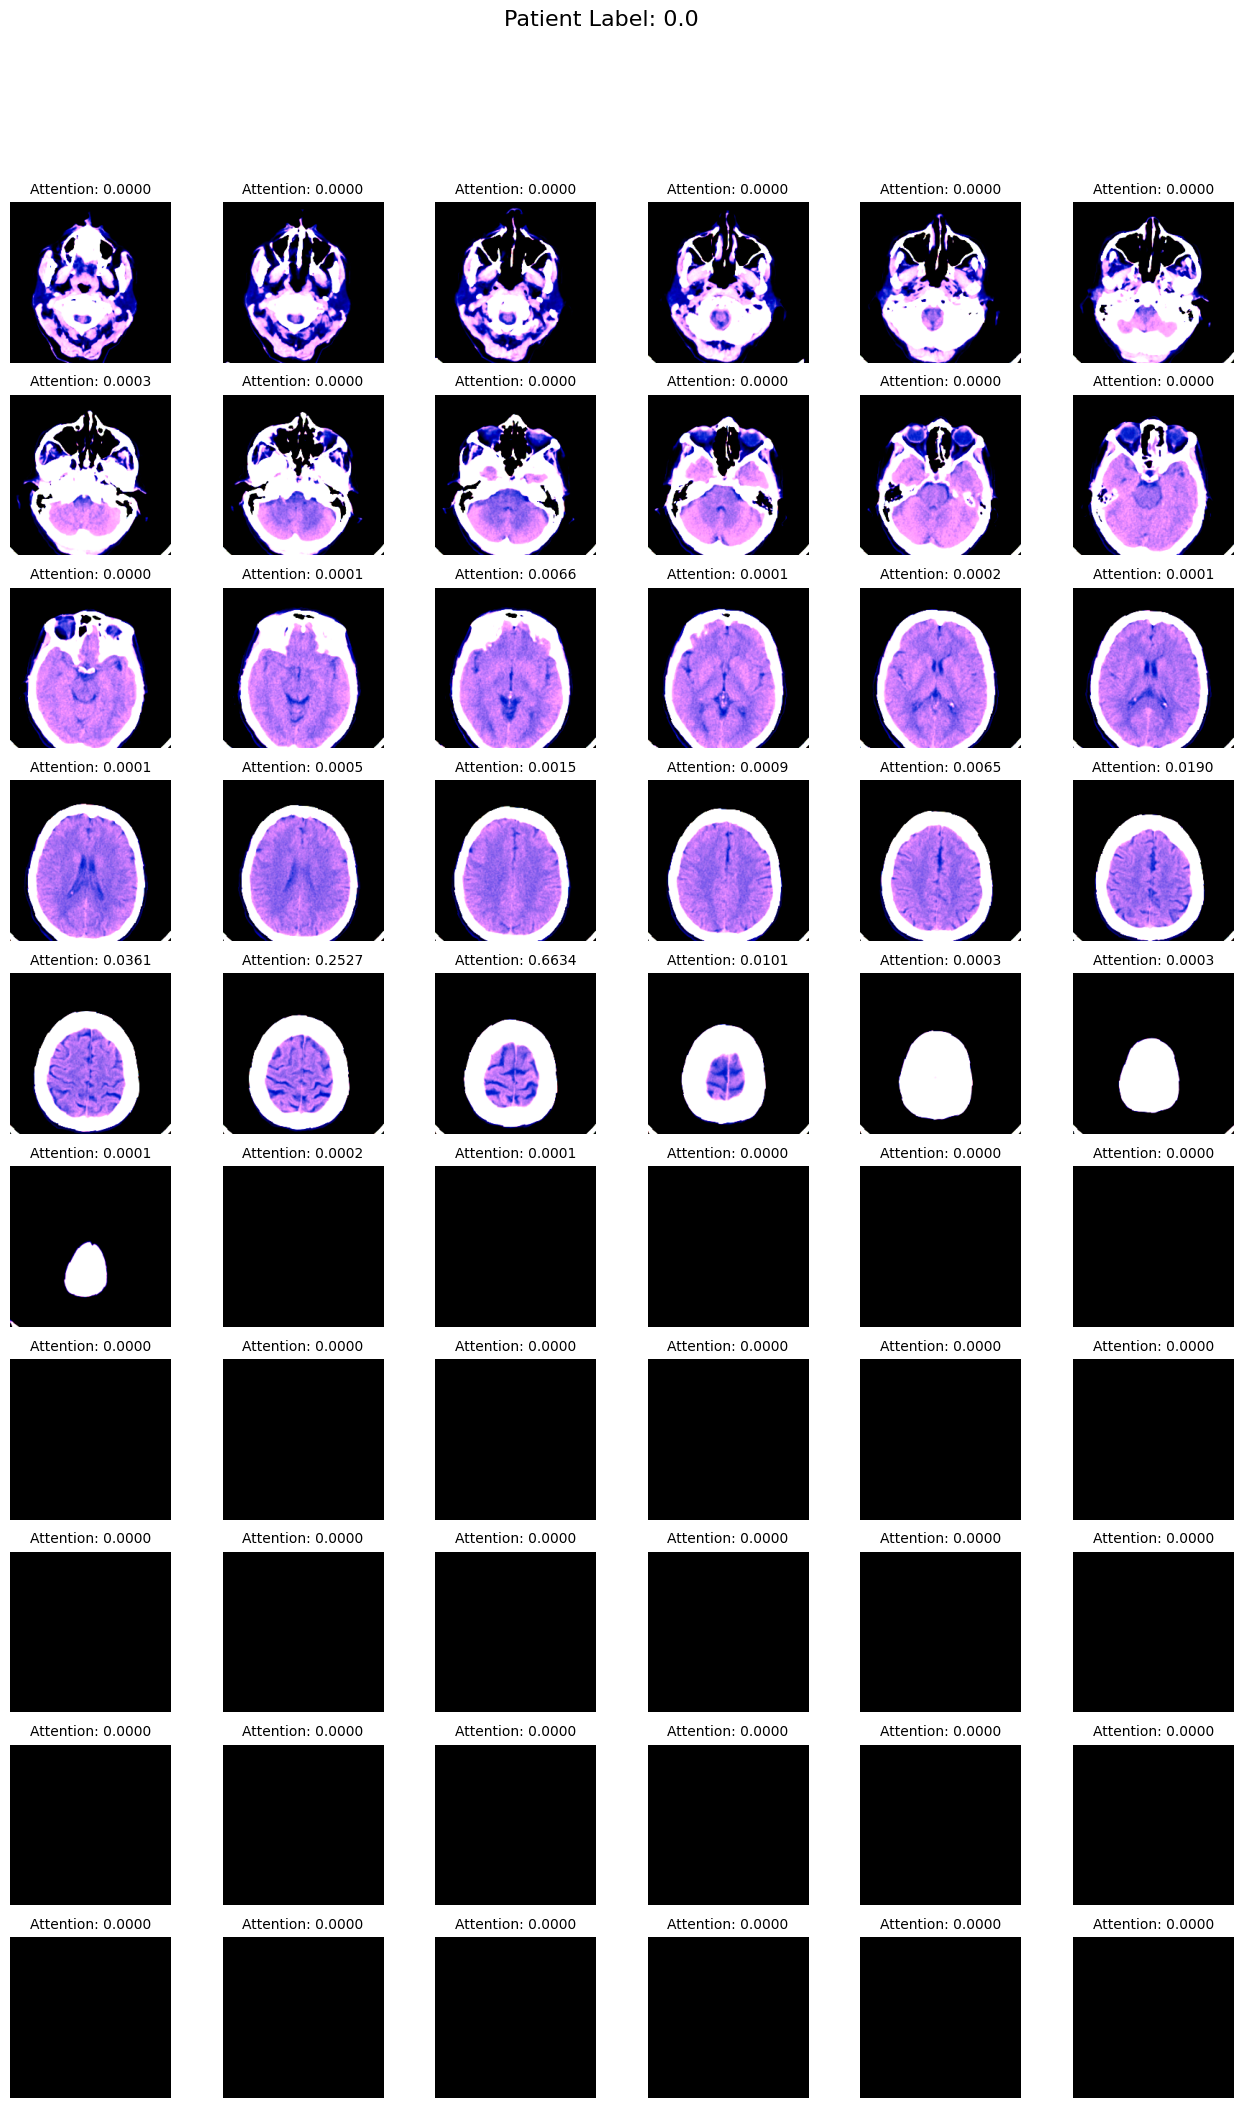

<Figure size 1600x800 with 0 Axes>

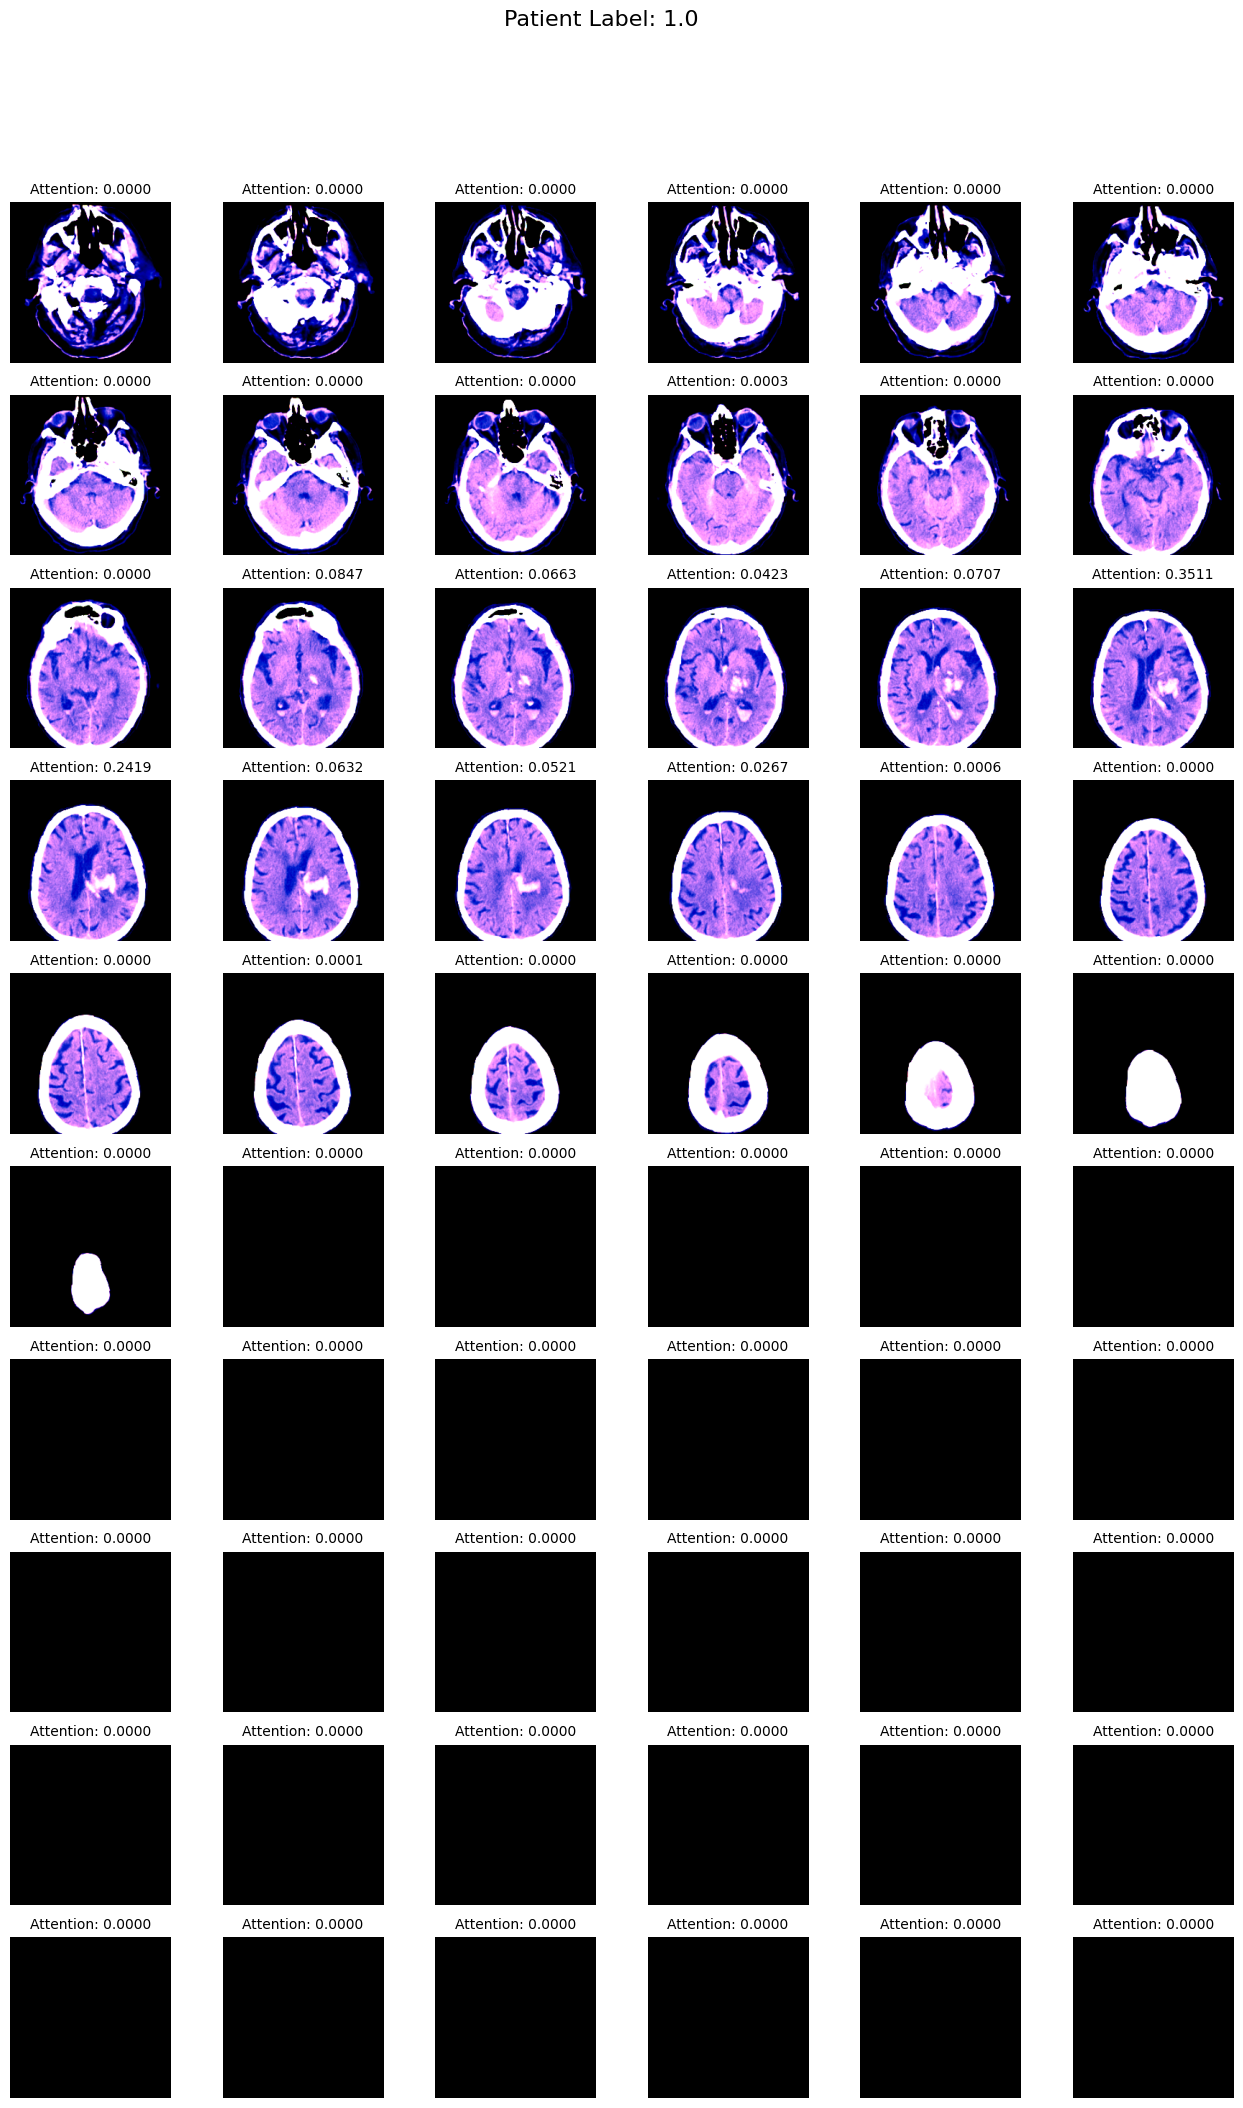

In [36]:
plot_images_with_attention(test_loader, model, device)